<a href="https://colab.research.google.com/github/gfelekis/ucl_bioinformatics_project/blob/master/bioinformatics_mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install Biopython

     |████████████████████████████████| 2.3MB 7.3MB/s 


In [0]:
import os 
# Science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
#Bio
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
# ML methods
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate

# Read data

In [0]:
filenames = {"mitocondrial": "mito.fasta",
             "nucleus"     : "nucleus.fasta", 
             "secreted"    : "secreted.fasta", 
             "cytoplasm"   : "cyto.fasta"}

In [5]:
!wget http://www0.cs.ucl.ac.uk/staff/D.Jones/coursework/cyto.fasta
!wget http://www0.cs.ucl.ac.uk/staff/D.Jones/coursework/secreted.fasta
!wget http://www0.cs.ucl.ac.uk/staff/D.Jones/coursework/mito.fasta
!wget http://www0.cs.ucl.ac.uk/staff/D.Jones/coursework/nucleus.fasta

--2020-03-23 18:16:46--  http://www0.cs.ucl.ac.uk/staff/D.Jones/coursework/cyto.fasta
Resolving www0.cs.ucl.ac.uk (www0.cs.ucl.ac.uk)... 128.16.6.8
Connecting to www0.cs.ucl.ac.uk (www0.cs.ucl.ac.uk)|128.16.6.8|:80... connected.
HTTP request sent, awaiting response... 200 Document follows
Length: 2350203 (2.2M) [text/plain]
Saving to: ‘cyto.fasta’

cyto.fasta          100%[===================>]   2.24M   323KB/s    in 7.3s    

2020-03-23 18:16:54 (314 KB/s) - ‘cyto.fasta’ saved [2350203/2350203]

--2020-03-23 18:16:55--  http://www0.cs.ucl.ac.uk/staff/D.Jones/coursework/secreted.fasta
Resolving www0.cs.ucl.ac.uk (www0.cs.ucl.ac.uk)... 128.16.6.8
Connecting to www0.cs.ucl.ac.uk (www0.cs.ucl.ac.uk)|128.16.6.8|:80... connected.
HTTP request sent, awaiting response... 200 Document follows
Length: 637227 (622K) [text/plain]
Saving to: ‘secreted.fasta’

secreted.fasta      100%[===================>] 622.29K   319KB/s    in 1.9s    

2020-03-23 18:16:57 (319 KB/s) - ‘secreted.fasta’ saved [6

In [0]:
reads    = {k: list(SeqIO.parse(v, "fasta")) for k,v in filenames.items()}
raw_seqs = {k: [[str(prot.id), str(prot.seq)] for prot in v] for k,v in reads.items()}
# raw_seqs

In [0]:
# organize dataset
ids    = [] 
seqs   = []
labels = []

index = 0
for k,v in raw_seqs.items():
    ids    += [prot[0] for prot in v]
    seqs   += [prot[1] for prot in v]
    labels += list(np.ones(len(v))*index)
    index  += 1
    
seqs   = np.array(seqs)
labels = np.array(labels) 

In [8]:
seqs.shape

(9222,)

# Feature extraction

In [0]:
data = pd.DataFrame()
data["id"]    = ids
data["seqs"]  = seqs
data["label"] = labels
data["label_loc"] = [list(filenames.keys())[int(label)] for label in labels]

In [10]:
data.head()

,id,seqs,label,label_loc
0,sp|Q9LVM1|AB25B_ARATH,MSRGSRFVRAPGLLLCRVNLQPQPKIPSFSYSLRSDYRLHNGFSNY...,0.0,mitocondrial
1,sp|P45844|ABCG1_HUMAN,MACLMAAFSVGTAMNASSYSAEMTEPKSVCVSVDEVVSSNMEATET...,0.0,mitocondrial
2,sp|Q9UKU7|ACAD8_HUMAN,MLWSGCRRFGARLGCLPGGLRVLVQTGHRSLTSCIDPSMGLNEEQK...,0.0,mitocondrial
3,sp|Q9H845|ACAD9_HUMAN,MSGCGLFLRTTAAARACRGLVVSTANRRLLRTSPPVRAFAKELFLG...,0.0,mitocondrial
4,sp|Q8NI60|ADCK3_HUMAN,MAAILGDTIMVAKGLVKLTQAAVETHLQHLGIGGELIMAARALQST...,0.0,mitocondrial


In [0]:
# 20 AAs, U for selenocysteine
aas = "HRKDESYTCQNMAVLIPWFGUBZ" # B/Z aspartate/asparragine + glutamate/glutamine
# length, weight, ... - reference: https://biopython.org/DIST/docs/api/Bio.SeqUtils.ProtParam.ProteinAnalysis-class.html#isoelectric_point
data["length"]     = [len(prot) for prot in seqs]
analyzed = [ProteinAnalysis(prot.replace("X", "").replace("B", "").replace("Z", "").replace("U", "")) for prot in seqs]
data["mol_weight"] = [prot.molecular_weight() for prot in analyzed]
data["mol_weight"] = data["mol_weight"]/100
data["gravy"]      = [prot.gravy() for prot in analyzed]
data["gravy"]      = np.abs(data["gravy"].values)
data["aromaticity"]      = [prot.aromaticity() for prot in analyzed]
# data["flexibility"]      = [prot.flexibility() for prot in analyzed]
data["isoelectric_point"]      = [prot.isoelectric_point() for prot in analyzed]
# relative occurrence of each AA
for i,aa in enumerate(aas):
    # relative percentage of abundance
    data["aa_"+str(aa)] = [prot.count(aa)/len(prot) for prot in seqs] # prot.count(aa)/len(prot)
    # times the AA occurs in the first 50 AAs
    data["aa_u50_"+str(aa)] = [prot[:50].count(aa) for prot in seqs] 
    data["aa_o50_"+str(aa)] = [prot[-50:].count(aa) for prot in seqs] 
    

In [0]:
additional_f = ["length", "mol_weight", "gravy", "aromaticity", "isoelectric_point"] # "flexibility"

In [0]:
# specific features
# sources: 
#    * Pepscan: http://shenlab.sols.unlv.edu/shenlab/labsite/bioinformatics/promoter/pepscan_output/search.htm
#    * Subcellular localization signal: http://metadb.riken.jp/metadb/db/SciNetS_ria138i/http://metadb.riken.jp/db/SciNetS_ria138i/cria138s4i

# endoplasmic reticulum 
# retention - KDEL on C terminus
data["signal_kdel"] = np.array([prot[-4:] == "KDEL" for prot in seqs])*1.0

# import into ER
data["signal_import_er"] = np.array([prot[:29] == "MMSFVSLLLVGILFWATEAEQLTKCEVFQ" for prot in seqs])*1.0

# nucleus
# NLS: nucleus localization signal
data["signal_nls"] = np.array(["PKKKRKV" in prot for prot in seqs])*1.0

# mitochondrial matrix localization
data["signal_mito"] = np.array([prot[:25] == "MLSLRQSIRFFKPATRTLCSSRYLL" for prot in seqs])*1.0

# other: peroxisome
data["signal_pero"] = np.array([prot[-3:] == "SKL" for prot in seqs])*1.0

# other: attatch to membrane
data["signal_memb"] = np.array([prot[-8:] == "ESSKSKPK" for prot in seqs])*1.0

additional = ["signal_kdel", "signal_import_er",
              "signal_nls", "signal_mito",
              "signal_pero", "signal_memb"]

In [14]:
data.head()

,id,seqs,label,label_loc,length,mol_weight,gravy,aromaticity,isoelectric_point,aa_H,aa_u50_H,aa_o50_H,aa_R,aa_u50_R,aa_o50_R,aa_K,aa_u50_K,aa_o50_K,aa_D,aa_u50_D,aa_o50_D,aa_E,aa_u50_E,aa_o50_E,aa_S,aa_u50_S,aa_o50_S,aa_Y,aa_u50_Y,aa_o50_Y,aa_T,aa_u50_T,aa_o50_T,aa_C,aa_u50_C,aa_o50_C,aa_Q,aa_u50_Q,aa_o50_Q,aa_N,...,aa_o50_M,aa_A,aa_u50_A,aa_o50_A,aa_V,aa_u50_V,aa_o50_V,aa_L,aa_u50_L,aa_o50_L,aa_I,aa_u50_I,aa_o50_I,aa_P,aa_u50_P,aa_o50_P,aa_W,aa_u50_W,aa_o50_W,aa_F,aa_u50_F,aa_o50_F,aa_G,aa_u50_G,aa_o50_G,aa_U,aa_u50_U,aa_o50_U,aa_B,aa_u50_B,aa_o50_B,aa_Z,aa_u50_Z,aa_o50_Z,signal_kdel,signal_import_er,signal_nls,signal_mito,signal_pero,signal_memb
0,sp|Q9LVM1|AB25B_ARATH,MSRGSRFVRAPGLLLCRVNLQPQPKIPSFSYSLRSDYRLHNGFSNY...,0.0,mitocondrial,728,804.191979,0.017857,0.089286,9.278748,0.013736,1,1,0.063187,8,1,0.045330,1,3,0.048077,1,4,0.043956,0,5,0.101648,7,3,0.026099,3,1,0.071429,0,1,0.005495,1,1,0.031593,2,5,0.048077,...,1,0.082418,1,3,0.065934,2,5,0.107143,6,6,0.064560,2,2,0.034341,4,1,0.006868,0,1,0.056319,3,0,0.060440,3,4,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,sp|P45844|ABCG1_HUMAN,MACLMAAFSVGTAMNASSYSAEMTEPKSVCVSVDEVVSSNMEATET...,0.0,mitocondrial,678,755.912257,0.162684,0.101770,8.024231,0.019174,0,1,0.053097,0,5,0.045723,1,3,0.042773,2,2,0.051622,5,4,0.087021,8,2,0.036873,1,3,0.047198,4,0,0.025074,2,1,0.029499,0,1,0.030973,...,0,0.069322,7,4,0.072271,6,3,0.126844,3,8,0.048673,0,6,0.035398,1,0,0.008850,0,0,0.056047,1,5,0.072271,1,1,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,sp|Q9UKU7|ACAD8_HUMAN,MLWSGCRRFGARLGCLPGGLRVLVQTGHRSLTSCIDPSMGLNEEQK...,0.0,mitocondrial,415,450.693150,0.050843,0.077108,8.121521,0.019277,1,2,0.057831,5,4,0.045783,2,1,0.040964,1,2,0.055422,3,3,0.074699,4,4,0.024096,0,4,0.043373,2,0,0.036145,3,1,0.048193,3,6,0.033735,...,2,0.098795,1,2,0.065060,2,4,0.089157,7,6,0.050602,1,3,0.031325,2,0,0.009639,1,0,0.043373,2,0,0.098795,7,4,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,sp|Q9H845|ACAD9_HUMAN,MSGCGLFLRTTAAARACRGLVVSTANRRLLRTSPPVRAFAKELFLG...,0.0,mitocondrial,621,687.595143,0.095491,0.075684,8.153870,0.017713,0,1,0.059581,7,2,0.062802,4,4,0.040258,0,3,0.077295,1,4,0.062802,3,3,0.025765,0,3,0.064412,4,1,0.017713,2,3,0.032206,0,5,0.038647,...,0,0.077295,7,4,0.062802,3,2,0.112721,7,7,0.064412,1,3,0.027375,2,2,0.003221,0,0,0.046699,3,1,0.082126,4,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,sp|Q8NI60|ADCK3_HUMAN,MAAILGDTIMVAKGLVKLTQAAVETHLQHLGIGGELIMAARALQST...,0.0,mitocondrial,647,719.493390,0.289026,0.086553,6.512390,0.032457,2,1,0.063369,1,4,0.051005,2,5,0.046368,1,0,0.075734,3,4,0.061824,1,4,0.021638,0,3,0.032457,4,1,0.013910,0,3,0.049459,4,3,0.032457,...,2,0.106646,9,4,0.051005,4,1,0.095827,7,4,0.043277,4,1,0.054096,0,4,0.003091,0,0,0.061824,0,3,0.072643,5,2,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Data split

In [0]:
x = data[["aa_"+str(aa) for aa in aas]+
         ["aa_u50_"+str(aa) for aa in aas]+
         ["aa_o50_"+str(aa) for aa in aas]+additional_f+additional]
y = data["label"]

# data split is not needed since we use CV and have test-specific data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# y_train = y_train.reshape(-1, 1)

In [48]:
print("x shape: ", x_train.shape)
print("y shape: ", y_train.shape)

x shape:  (7377, 80)
y shape:  (7377,)


# Model training

In [49]:
# limitting the max_depth doesn't solve the overfitting problem

clf        = RandomForestClassifier(max_depth=27, n_jobs=-1)
cv_results = cross_validate(clf, x, y, cv=7)
print("CV mean:", np.mean(cv_results["test_score"]))
cv_results

CV mean: 0.6226383758158622


{'fit_time': array([2.55413151, 2.53957653, 2.54979634, 2.51932406, 2.49987292,
        2.51314688, 2.54963541]),
 'score_time': array([0.10476732, 0.10420227, 0.10470748, 0.10494661, 0.1044476 ,
        0.10460186, 0.10419393]),
 'test_score': array([0.62367223, 0.63808801, 0.63505311, 0.60668185, 0.58694002,
        0.6340167 , 0.6340167 ])}

In [50]:
print("Mean of test accuracy: ", np.mean(cv_results["test_score"]))

Mean of test accuracy:  0.6226383758158622


In [0]:
# Estimate the confusion matrix in the test set

In [52]:
clf.fit(x_train, y_train)
print("Model trained")
preds_train = clf.predict(x_train)
acc_train   = np.mean(preds_train == y_train)
print("Train Accuracy: ", acc_train)

Model trained
Train Accuracy:  1.0


In [53]:
# ml test:
preds_test = clf.predict(x_test)
acc_preds  = np.mean(preds_test == y_test)
print("Test Accuracy: ", acc_preds)
# predict probabilities: 
probs = clf.predict_proba(x_test)

Test Accuracy:  0.6493224932249323


We split the data set in 80% training(including validation) and 20% test to take an insigth view of a confusion matrix. Later on we will retrain our model to the whole dataset to see how it performs on unknown protein sequences ("Blind Test" Proteins). 

Normalized confusion matrix


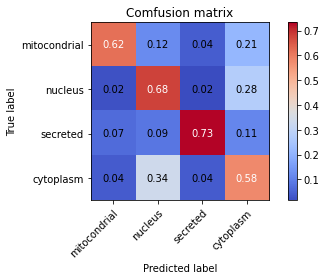

In [54]:
matrix = cm = confusion_matrix(y_test, preds_test)

title = "Comfusion matrix"
cmap = "coolwarm"
normalize = True

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
else:
    print('Confusion matrix, without normalization')

# print(cm)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=list(filenames.keys()), yticklabels=list(filenames.keys()),
       title=title,
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

# Make predictions

In [55]:
!wget http://www0.cs.ucl.ac.uk/staff/D.Jones/coursework/blind.fasta

--2020-03-23 18:33:50--  http://www0.cs.ucl.ac.uk/staff/D.Jones/coursework/blind.fasta
Resolving www0.cs.ucl.ac.uk (www0.cs.ucl.ac.uk)... 128.16.6.8
Connecting to www0.cs.ucl.ac.uk (www0.cs.ucl.ac.uk)|128.16.6.8|:80... connected.
HTTP request sent, awaiting response... 200 Document follows
Length: 11285 (11K) [text/plain]
Saving to: ‘blind.fasta.1’

blind.fasta.1       100%[===================>]  11.02K  --.-KB/s    in 0.04s   

2020-03-23 18:33:50 (288 KB/s) - ‘blind.fasta.1’ saved [11285/11285]



In [0]:
def predict(model, seq):
    feats = [[seq.count(aa) for aa in aas]+
             [seq[ :50].count(aa) for aa in aas]+
             [seq[-50:].count(aa) for aa in aas]+[len(seq)]]
    # add new physicchemical features
    analyzed = ProteinAnalysis(seq.replace("X", "").replace("B", "").replace("Z", "").replace("U", ""))
    feats[0].append(analyzed.molecular_weight())
    feats[0].append(analyzed.gravy())
    feats[0].append(analyzed.aromaticity())
    feats[0].append(analyzed.isoelectric_point())
    # add new features 
    feats[0].append(float(seq[-4:] == "KDEL"))
    feats[0].append(float(seq[:29] == "MMSFVSLLLVGILFWATEAEQLTKCEVFQ"))
    feats[0].append(float("PKKKRKV" in seq))
    feats[0].append(float(seq[:25] == "MLSLRQSIRFFKPATRTLCSSRYLL"))
    feats[0].append(float(seq[-3:] == "SKL"))
    feats[0].append(float(seq[-8:] == "ESSKSKPK"))
    
    # predictions
    preds = model.predict_proba(feats)
    pred  = list(filenames.keys())[np.argmax(preds, axis=1)[0]] 
    result= {"pred": pred, "probability": {k:preds[0][i] for i,k in enumerate(filenames.keys())}} 
    return result

In [0]:
# train the model with the whole data to make predictions for the blinded-test proteins
clf.fit(x, y);

In [0]:
reads    = list(SeqIO.parse("blind.fasta", "fasta"))

In [0]:
test_data = {str(prot.id): {"seq": str(prot.seq), "prediction": None, "confidence": None} for prot in reads}

In [0]:
for k,v in test_data.items():
  pred = predict(clf, test_data[k]["seq"])
  test_data[k]["prediction"] = pred["pred"][:4].capitalize()
  test_data[k]["confidence"] = str(pred["probability"][pred["pred"]]*100)+"%"

In [61]:
for k, v in test_data.items():
  print(k, v["prediction"], "Confidence", v["confidence"])

SEQ677 Secr Confidence 40.0%
SEQ231 Secr Confidence 38.0%
SEQ871 Secr Confidence 37.0%
SEQ388 Secr Confidence 41.0%
SEQ122 Secr Confidence 35.0%
SEQ758 Secr Confidence 33.0%
SEQ333 Cyto Confidence 32.0%
SEQ937 Secr Confidence 41.0%
SEQ351 Nucl Confidence 28.999999999999996%
SEQ202 Secr Confidence 40.0%
SEQ608 Secr Confidence 35.0%
SEQ402 Secr Confidence 42.0%
SEQ433 Secr Confidence 42.0%
SEQ821 Secr Confidence 35.0%
SEQ322 Secr Confidence 43.0%
SEQ982 Secr Confidence 45.0%
SEQ951 Secr Confidence 34.0%
SEQ173 Cyto Confidence 34.0%
SEQ862 Secr Confidence 35.0%
SEQ224 Secr Confidence 42.0%
